In [1]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import json
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [2]:
seed = 42
random.set_seed(seed)
np.random.seed(seed)


In [3]:
styles_path = '../styles.csv'

df = pd.read_csv(styles_path, on_bad_lines='skip')

df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
category_counts = df['articleType'].value_counts()

pd.set_option('display.max_rows', None) 
print(category_counts)

articleType
Tshirts                      7067
Shirts                       3217
Casual Shoes                 2845
Watches                      2542
Sports Shoes                 2036
Kurtas                       1844
Tops                         1762
Handbags                     1759
Heels                        1323
Sunglasses                   1073
Wallets                       936
Flip Flops                    914
Sandals                       897
Briefs                        849
Belts                         813
Backpacks                     724
Socks                         686
Formal Shoes                  637
Perfume and Body Mist         613
Jeans                         609
Shorts                        547
Trousers                      530
Flats                         500
Bra                           477
Dresses                       464
Sarees                        427
Earrings                      416
Deodorant                     347
Nail Polish                   329
Li

In [5]:
# ucinamy zbiór na 416 (zaleca sie 500)

In [6]:
df.isnull().sum()


id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [7]:
df.isnull().sum()
df.dropna(inplace=True)

In [8]:
df.isnull().sum()


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64

In [9]:
images_path = '../images/'

df['image_path'] = df['id'].apply(lambda x: os.path.join(images_path, f"{x}.jpg"))
df = df[df['image_path'].apply(os.path.exists)].copy() 

In [10]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,../images/15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,../images/39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,../images/59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,../images/21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,../images/53759.jpg


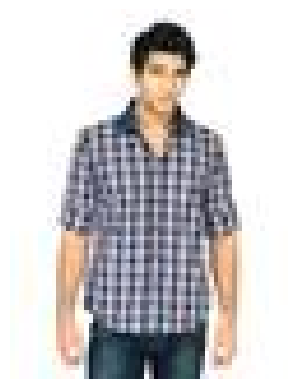

In [11]:
first_image_path = df['image_path'].iloc[0]

image = Image.open(first_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [12]:
category_counts = df['articleType'].value_counts()

min_count = 400

# filtered_categories = category_counts[category_counts >= min_count].index
filtered_categories = category_counts[(category_counts > min_count) & (category_counts.index != 'Flats')].index

df = df[df['articleType'].isin(filtered_categories)]

category_counts = df['articleType'].value_counts()

for category, count in category_counts.items():
    print(f"{category}: {count}")

Tshirts: 7065
Shirts: 3212
Casual Shoes: 2845
Watches: 2542
Sports Shoes: 2016
Kurtas: 1844
Tops: 1762
Handbags: 1759
Heels: 1323
Sunglasses: 1073
Wallets: 928
Flip Flops: 914
Sandals: 895
Briefs: 847
Belts: 813
Backpacks: 724
Socks: 686
Formal Shoes: 637
Perfume and Body Mist: 603
Jeans: 602
Shorts: 547
Trousers: 530
Bra: 477
Dresses: 464
Sarees: 427
Earrings: 416


In [13]:
df.isnull().sum()
df.dropna(inplace=True)
df.isnull().sum()


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
image_path            0
dtype: int64

In [14]:
df.to_csv('../backend/dataframe.csv', index=False)

In [15]:
# preprocessing obrazków:

# def preprocess_image(image_path, target_size=(128, 128)):
#     img = load_img(image_path, target_size=target_size)
#     img_array = img_to_array(img) / 255.0  # Normalizacja
#     return img_array


In [16]:
def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

In [17]:
images = np.array([img for img in (preprocess_image(path) for path in df['image_path'])])

In [18]:
df['label'] = df['articleType'].astype('category').cat.codes

In [19]:
X_train, X_test, y_train, y_test = train_test_split(images, df['label'], test_size=0.2, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [20]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (28760, 128, 128, 3)
y_train shape: (28760, 26)
X_test shape: (7191, 128, 128, 3)
y_test shape: (7191, 26)


In [21]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

In [22]:
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(128, activation='relu')(x)  
x = Dropout(0.5)(x) 
predictions = Dense(y_train.shape[1], activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,425,306 (9.25 MB)

 Trainable params: 167,322 (653.60 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
    
)

Epoch 1/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 68s 93ms/step - accuracy: 0.4061 - loss: 2.1985 - val_accuracy: 0.8128 - val_loss: 0.6030
Epoch 2/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 63s 88ms/step - accuracy: 0.7514 - loss: 0.7839 - val_accuracy: 0.8578 - val_loss: 0.4348
Epoch 3/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 75s 105ms/step - accuracy: 0.8163 - loss: 0.5724 - val_accuracy: 0.8720 - val_loss: 0.3795
Epoch 4/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 78s 109ms/step - accuracy: 0.8383 - loss: 0.4957 - val_accuracy: 0.8814 - val_loss: 0.3512
Epoch 5/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.8590 - loss: 0.4405 - val_accuracy: 0.8847 - val_loss: 0.3313
Epoch 6/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.8662 - loss: 0.4039 - val_accuracy: 0.8879 - val_loss: 0.3199
Epoch 7/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.8750 - loss: 0.3726 - val_accuracy: 0.8922 - val_loss: 0.3070
Epoch 8/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.8851 - loss: 0.3

In [25]:
print('last validation loss:', history.history['val_loss'][-1])
print('last validation accuracy:', history.history['val_accuracy'][-1])

last validation loss: 0.29005032777786255
last validation accuracy: 0.9010778665542603


In [26]:
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(y=history.history['loss'], mode='lines', name='Train Loss'))
fig_loss.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig_loss.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig_loss.show()

fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(y=history.history['accuracy'], mode='lines', name='Train Accuracy'))
fig_acc.add_trace(go.Scatter(y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig_acc.update_layout(title='Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig_acc.show()

In [27]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

raport = classification_report(y_true, y_pred_classes)
print(raport)

225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       131
           1       0.99      0.99      0.99       155
           2       0.99      0.99      0.99        91
           3       0.98      0.95      0.96       173
           4       0.82      0.78      0.79       552
           5       0.73      0.68      0.70        94
           6       0.96      1.00      0.98        81
           7       0.83      0.85      0.84       185
           8       0.77      0.87      0.82       125
           9       0.96      0.94      0.95       352
          10       0.88      0.83      0.86       302
          11       0.90      0.96      0.93       119
          12       0.90      0.92      0.91       379
          13       0.98      0.97      0.97       134
          14       0.79      0.82      0.80       182
          15       0.98      0.99      0.98        92
          16       0.90      0.94    

In [28]:
# Mapowanie labeli do nazwa ArticleType
labels = df['label'].values 
label_mapping = dict(enumerate(df['articleType'].astype('category').cat.categories))
print(label_mapping)

{0: 'Backpacks', 1: 'Belts', 2: 'Bra', 3: 'Briefs', 4: 'Casual Shoes', 5: 'Dresses', 6: 'Earrings', 7: 'Flip Flops', 8: 'Formal Shoes', 9: 'Handbags', 10: 'Heels', 11: 'Jeans', 12: 'Kurtas', 13: 'Perfume and Body Mist', 14: 'Sandals', 15: 'Sarees', 16: 'Shirts', 17: 'Shorts', 18: 'Socks', 19: 'Sports Shoes', 20: 'Sunglasses', 21: 'Tops', 22: 'Trousers', 23: 'Tshirts', 24: 'Wallets', 25: 'Watches'}


In [29]:
image_path = os.path.join(images_path, '1163.jpg')

image_array = preprocess_image(image_path, target_size=(128, 128))

image_array = np.expand_dims(image_array, axis=0)

prediction = model.predict(image_array)

predicted_class = np.argmax(prediction, axis=1)[0]

predicted_label = label_mapping[predicted_class]
print(f"Predykcja dla obrazka {image_path}: Label: {predicted_class}, Klasa: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predykcja dla obrazka ../images/1163.jpg: Label: 23, Klasa: Tshirts


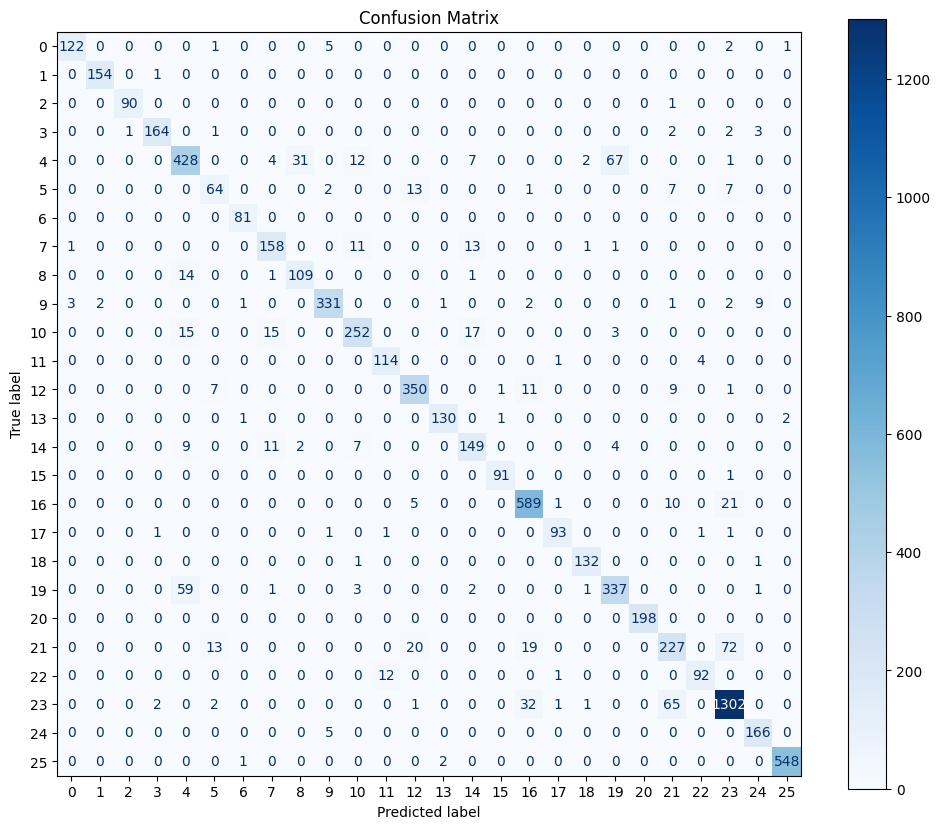

In [30]:
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap=plt.cm.Blues)

display.figure_.set_size_inches(12, 10)
plt.title('Confusion Matrix')
plt.show()

In [41]:
model.save('../backend/best_model_noflats.keras')

<h4>Zapisanie dictionary labele: nazwy</h4>

In [42]:
df['label'] = df['articleType'].astype('category').cat.codes 
labels = df['label'].values 
label_mapping = dict(enumerate(df['articleType'].astype('category').cat.categories))
print(label_mapping)

with open('../backend/label_mapping.json', 'w') as f:
    json.dump(label_mapping, f)

{0: 'Backpacks', 1: 'Belts', 2: 'Bra', 3: 'Briefs', 4: 'Casual Shoes', 5: 'Dresses', 6: 'Earrings', 7: 'Flip Flops', 8: 'Formal Shoes', 9: 'Handbags', 10: 'Heels', 11: 'Jeans', 12: 'Kurtas', 13: 'Perfume and Body Mist', 14: 'Sandals', 15: 'Sarees', 16: 'Shirts', 17: 'Shorts', 18: 'Socks', 19: 'Sports Shoes', 20: 'Sunglasses', 21: 'Tops', 22: 'Trousers', 23: 'Tshirts', 24: 'Wallets', 25: 'Watches'}


<h4>Zapisanie nazw plików ze zbiory testowego</h4>

In [43]:
test_indices = df.index[X_test.shape[0]:]

test_image_paths = df.loc[test_indices, 'image_path'].apply(lambda x: os.path.basename(x)).tolist()

test_image_paths_subset = test_image_paths[:1000]

with open('../backend/test_images.json', 'w') as f:
    json.dump(test_image_paths_subset, f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predykowana kategoria: 12


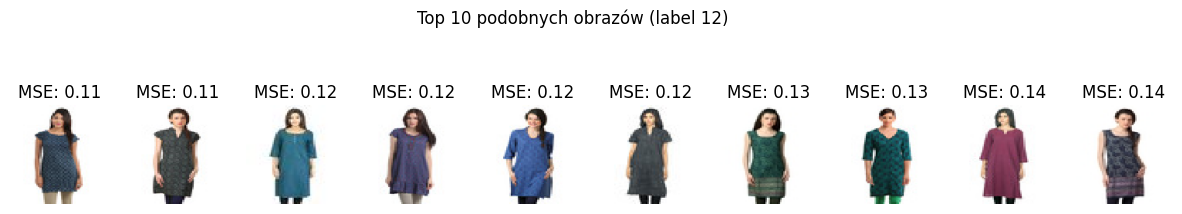

Najbardziej podobne obrazy:
../images/49776.jpg
../images/42653.jpg
../images/23306.jpg
../images/52109.jpg
../images/42681.jpg
../images/30840.jpg
../images/42677.jpg
../images/53410.jpg
../images/30843.jpg
../images/42678.jpg


In [40]:
from sklearn.metrics import mean_squared_error

def mse(img1, img2):
    return mean_squared_error(img1.flatten(), img2.flatten())


def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

# 3. Definicja find_similar_images
def find_similar_images(model, df, input_image_path, top_n=10):
    input_img = preprocess_image(input_image_path)
    input_img_batch = np.expand_dims(input_img, axis=0)

    predicted_probs = model.predict(input_img_batch)
    predicted_class_index = np.argmax(predicted_probs)
    predicted_class_label = predicted_class_index

    print(f"Predykowana kategoria: {predicted_class_label}")

    same_class_paths = df[df['label'] == predicted_class_label]['image_path'].values

    mse_scores = []
    for path in same_class_paths:
        img = preprocess_image(path)
        score = mse(input_img, img)
        mse_scores.append((path, score))

    top_matches = sorted(mse_scores, key=lambda x: x[1])[:top_n]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 3))
    for i, (path, score) in enumerate(top_matches):
        matched_img = load_img(path, target_size=(128, 128))
        plt.subplot(1, top_n, i + 1)
        plt.imshow(matched_img)
        plt.title(f"MSE: {score:.2f}")
        plt.axis('off')
    plt.suptitle(f"Top {top_n} podobnych obrazów (label {predicted_class_label})")
    plt.show()

    return [path for path, _ in top_matches]

# 4. Przygotowanie df, model itd. i wywołanie:
df = df.reset_index(drop=True)
similar_images = find_similar_images(model, df, input_image_path="../images/39716.jpg", top_n=10)

print("Najbardziej podobne obrazy:")
for path in similar_images:
    print(path)